# Setting boundaries on model parameters

In previous parts of the tutorial we've looked at simulation methods and performed some basic fitting.

In this notebook, we'll try to set some _boundaries_ on the parameter values we expect.
This will make our life easier in three ways:

1. By staying within a sensible region of parameter space, we can avoid numerical issues
2. By reducing the size of the search space, we can speed up optimisations and make them more robust
3. By sampling from within known boundaries we can derive random parameter sets to use as starting points for our search.

## Dealing with simulation issues in a ForwardModel

First, we'll show what can happen when you don't define boundaries.
We'll begin by defining a forward model that uses the `myokit.Simulation` class:

In [ ]:
import matplotlib.pyplot as plt
import myokit
import myokit.lib.hh
import numpy as np
import pints

class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create a Simulation
        self.sim = myokit.Simulation(model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        log = self.sim.run(times[-1] + 0.1, log_times=times, log=['ikr.IKr'])
        return log['ikr.IKr']    

In [2]:
# Load a protocol and create a foward model instance
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Evaluate the model
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)

So far so good! Now let's try some random parameters

In [3]:
np.random.seed(5)
parameters = np.random.lognormal(0, 2, 9)
values = model.simulate(parameters, times)

SimulationError: Function CVode() failed with flag -3 CV_ERR_FAILURE: Error test failures occurred too many times during one internal time step or minimum step size was reached.

That doesn't look too good!

The `SimulationError` above tells us the ODE solver (CVODE), has either had too many "test failures", or its "minimum step size was reached".
In other words, at some point during the simulation the solver was unable to determine a step size that would lead to a good prediction for the next step.

So what can we do about it?
A first thought might be to catch the errors, and return some other output, i.e. a list of `NaN` objects:

In [4]:
class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create a Simulation
        self.sim = myokit.Simulation(model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        try:
            log = self.sim.run(times[-1] + 0.1, log_times=times, log=['ikr.IKr'])
            return log['ikr.IKr']    
        except myokit.SimulationError:
            print('Error evaluating with parameters: ' + str(parameters))
            return np.nan * times

# Create a new model and try again
model = Model(protocol)

values = model.simulate(parameters, times)

print()
print('Values:')
print(values)

Error evaluating with parameters: [  2.41682567   0.51595264 129.22335923   0.60399808   1.24510478
  23.68784942   0.16227468   0.30627456   1.45529183]

Values:
[nan nan nan ... nan nan nan]


That's _sort of_ better...
Now if we define some error involving this time series, it will evaluate to `nan` ("not a number").
As long as the optimisation routine can deal with that, it means we're OK?

Since this is a simple step protocol, we could also try using an analytical simulation:

In [5]:
class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create an analytical simulation
        self.sim = myokit.lib.hh.AnalyticalSimulation(hh_model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        self.sim.set_parameters(parameters)
        log = self.sim.run(times[-1] + 0.1, log_times=times)
        return log['ikr.IKr']    

# Create a new model and try again
model = Model(protocol)

values = model.simulate(parameters, times)

print()
print('Values:')
print(values)


Values:
[1.35065787e-03 1.67013286e-40 1.67013286e-40 ... 1.67013286e-40
 1.67013286e-40 1.67013286e-40]


<string>:9: RuntimeWarning: overflow encountered in exp
<string>:14: RuntimeWarning: divide by zero encountered in true_divide
<string>:14: RuntimeWarning: invalid value encountered in true_divide


This seems to evaluate -- although with a lot of warnings, and the results don't look very sensible either!

So now we can write simulations that don't fall over if the parameters are bad, but there's still some major downsides:

- Not all optimisation routines will be able to deal with `nan` or `inf`
- Even an optimiesr that can deal with these values can easily get stuck, or waste a lot of time, it it's searching a region where every point returns an invalid value.
- We spent some computational effort doing a partial simulation, but didn't really learn much - except that we probably shouldn't have tried these parameters in the first place! It'd be better if we could avoid these simulations altogether.
- Catching errors like this could hide bugs in our implementation

Let's try to be a bit more clever and define _boundaries_ on the parameter space.

## How to come up with parameter bounds

To derive parameter bounds, we start by taking another look at our model.
If you skipped the [introduction](introduction.ipynb) it might be worthwhile having a quick look at the parts where we describe the reaction rates.

$$ I = g_\text{max} \cdot a \cdot r \cdot (V - E) $$

\begin{align}
\dot{a} = (1 - a)k_1 - a k_2    &&& k1 = p_1 \exp(p_2 V) \\
                                &&& k2 = p_3 \exp(-p_4 V) \\
\dot{r} = (1 - r)k_4 - r k_3    &&& k3 = p_5 \exp(p_6 V) \\
                                &&& k4 = p_7 \exp(-p_8 V)
\end{align}

$$p_9 = g_\text{max} $$


First, we'll see what we can figure out _without_ any experimental data.

Of the 9 parameters, `p9` is easiest to interpret: It represents the maximum conductance, i.e. the total conductance if all of the channels would be open.
So we can immediately say it must be a positive number.

In the [introduction](introduction.ipynb), we also looked at $a_i$ and $b_i$, and decided that:

- the $a_i$ parameters are positive, with the same units and roughly the same magnitude as the overal rates $k_i$
- the $b_i$ parameters are (postulated to be) positive, and if we use $V$ in mV, they are most likely small: $0 \leq b_i < 1$.

### Rates and a-parameters

Looking first at the rates, 



### MAybe look at half-life?

Next, we can rewrite the equation for activation as

\begin{align}
\frac{da}{dt} = \frac{a - a_\infty}{\tau_a} &&& a_\infty = \frac{k1}{k1 + k2} &&& \tau_a = \frac{1}{k_1 + k_2}
\end{align}

and solve for a fixed $V$ to find
\begin{align}
a(t, V=V_\text{fixed}) = a_\infty + (a_0 - a_\infty) e^{-t/\tau_a}
\end{align}

which is an [exponential decay](https://en.wikipedia.org/wiki/Exponential_decay) process with a [half-life](https://en.wikipedia.org/wiki/Half-life) of 
$$t_{1/2} = \tau_a \ln(2) = \frac{\ln(2)}{k_1 + k_2}$$

Assuming that $k_1$ is of the same order of magnitude as $k_2$,


## Basing boundaries on previous data

We could also try looking at some previous data for the channel we're trying to esimate.
For example, the graph below shows some data digitized from figure 13a of [hERG K+ Channels: Structure, Function, and Clinical Significance](https://journals.physiology.org/doi/full/10.1152/physrev.00036.2011), by Jamie Vandenberg et al.:


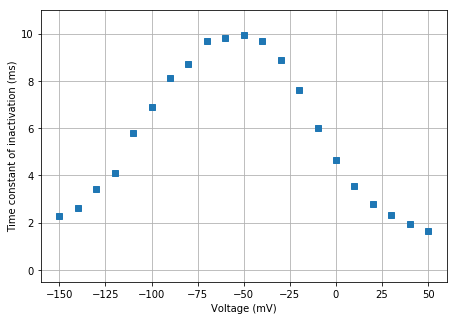

In [6]:
import numpy as np
import matplotlib.pyplot as plt

voltage = np.arange(-150, 60, 10)
tau_r = np.array([
    2.2966, 2.6435, 3.4241, 4.1006, 5.7832, 6.876, 8.1422, 
    8.6973, 9.686, 9.8075, 9.9289, 9.6687, 8.9055, 7.6219,
    6.026, 4.673, 3.5455, 2.7954, 2.314, 1.9366, 1.6548])

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)
plt.grid(True)
plt.show()

Next, Vandenberg et al. make some great observations:
First, they define $k_\text{observed} = k_3 + k_4 = 1 / \tau_r$, and plot this on a semi-log scale:

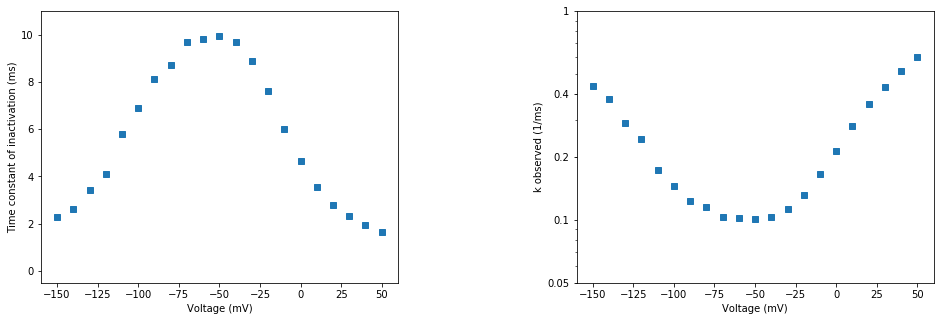

In [7]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)

ax = plt.subplot(1, 2, 2)
plt.semilogy()
plt.xlabel('Voltage (mV)')
plt.ylabel('k observed (1/ms)')
plt.plot(voltage, 1 / tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(5e-2, 1)
ax.set_yticks([5e-2, 1e-1, 2e-1, 4e-1, 1])
ax.set_yticklabels([5e-2, 1e-1, 2e-1, 4e-1, 1])

plt.subplots_adjust(wspace=0.5)
plt.show()

We can then make some quick and dirty calculations:

- It seems that there's plenty of voltage sensitivity
- Since $k_\text{observered} = k_3 + k_4 = a_3 e^{+b_3 V} + a_4 e^{-b_4 V}$, we can assume that the points on the far right (where $V$ is very positive) are dominated by $k_3$ (the rate of inactivation), while thepoints on the far left (where $V$ is very negative) are dominated by $k_4$ (the rate of recovery).
- So we can fit lines to these points, and use them to estimate the $a$'s and $b$'s

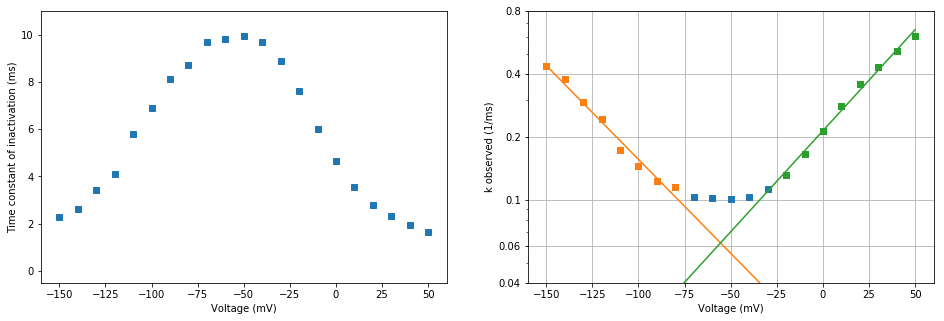

Esimates:
a3: 0.2138594262779559
b3: 0.022277787488105823
a4: 0.019680009317219783
b4: 0.02069200269754123


In [31]:
# Log of k observed
logk = np.log(1 / tau_r)

# Left: rate of recovery k_4 = a_4 e^(b_4 V)
n4 = 8
b4, log_a4 = np.polyfit(voltage[:n4], logk[:n4], 1)
a4 = np.exp(log_a4)
k4 = a4 * np.exp(b4 * voltage)

# Right: rate of recovery k_4 = a_4 e^(b_4 V)
n3 = -8
b3, log_a3 = np.polyfit(voltage[n3:], logk[n3:], 1)
a3 = np.exp(log_a3)
k3 = a3 * np.exp(b3 * voltage)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)

ax = plt.subplot(1, 2, 2)
plt.semilogy()
plt.xlabel('Voltage (mV)')
plt.ylabel('k observed (1/ms)')
plt.plot(voltage, 1 / tau_r, 's')
plt.plot(voltage[:n4], 1 / tau_r[:n4], 's', color='tab:orange')
plt.plot(voltage, k4, color='tab:orange')
plt.plot(voltage[n3:], 1 / tau_r[n3:], 's', color='tab:green')
plt.plot(voltage, k3, color='tab:green')
plt.xlim(-160, 60)
plt.ylim(4e-2, 0.6)
ax.set_yticks([0.04, 0.06, 0.1, 0.2, 0.4, 0.8])
ax.set_yticklabels([4e-2, 0.06, 0.1, 0.2, 0.4, 0.8])
plt.grid(True)

plt.show()

print('Esimates:')
print('a3: ' + str(a3))
print('b3: ' + str(b3))
print('a4: ' + str(a4))
print('b4: ' + str(-b4))

While this is an approximation, and only one experiment, it gives us an idea of the _expected magnitude_ for the parameters for inactivation/recovery: $a \approx 10^{-1}$, $b \approx 10^{-2}$.

## Using boundaries in an optimisation

TODO: Example with simple rectangular boundaries

## Setting boundaries on rates

## Summary

In this part of the tutorial, we have

- Lalala

In the next part